In [2]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from math import sqrt
import  pylab as pl
import numpy as np
from datetime import timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import hierarchical_portfolio
from pyhrp.hrp import dist, linkage, tree, _hrp
from scipy.cluster.hierarchy import dendrogram, linkage

In [57]:
def cluster_returns(x, y):
    # save returns for each cluster in dictionary
    # takes as input a dataframe containing the assets and corresponding cluster index (x) and a matrix of returns (y)
    # returns a dictionary containing the returns for each cluster
    (unique, counts) = np.unique(x["Cluster"], return_counts=True)
    
    ret_dict = {}
    for i in unique: 
        lgc = x["Cluster"] == i
        ret_dict[i] = y.loc[:,lgc.values]
    
    return(ret_dict)

In [58]:
def equal_weights(x):
    # computes equally weighted portfolio returns for each cluster
    # takes a dictionary containing the cluster returns as input (output of cluster_returns)
    # returns a dataframe containing the equally weighted portfolio returns
    ret_ew = pd.DataFrame()

    for i in x.keys(): 
        ret_ew = ret_ew.append(x[i].mean(axis = 1), ignore_index = True)

    ret_ew = ret_ew.T
    
    return(ret_ew)

In [59]:
def rolling_portfolio(x, clust_type):
    # computes optimal portfolio weights on 252 days rolling windows (daily portfolio rebalancing)
    # takes dataframe of cluster returns as input (output of equal_weights)
    # returns dataframe of optimal portfolio weights for each cluster
    window = 252

    #pesi_df = pd.DataFrame()
    pesi_dict = {}
    dates_dict = {}

    rets_rolling = x.iloc[i:(i+window),:] 

    for i in range( len(x) - window - 1 ):

        if clust_type == "partitional":
            # expected returns and sample covariance 
            cluster_price = expected_returns.prices_from_returns(rets_rolling)
            mu = expected_returns.mean_historical_return(cluster_price)
            S = risk_models.sample_cov(cluster_price)

            # maximum sharpe ratio (tangency) portfolio weights 
            ef = EfficientFrontier(mu, S)
            raw_weights = ef.max_sharpe()
            weights_fin = ef.clean_weights()
        else:
            hrp = hierarchical_portfolio.HRPOpt(rets_rolling)
            raw_weights = hrp.optimize()
            weights_fin = hrp.clean_weights()

        #pesi_df = pesi_df.append( pd.DataFrame(weights_fin.values()).T )
        pesi_dict[i] = weights_fin.values()
        dates_dict[i] = rets_rolling.index[-1] 

    #pesi_df.index = pd.Index(dates_dict.values())

    pesi_df = pd.DataFrame(pesi_dict.values())
    pesi_df.index = pd.Index(dates_dict.values())
    pesi_df.columns = x.columns

    return(pesi_df)

In [60]:
def static_portfolio(x):
    # performs static portfolio optimization
    # takes dataframe of cluster returns as input (output of equal_weights)
    # returns dictionary of optimal portfolio weights for each cluster

    cluster_price = expected_returns.prices_from_returns(x)
    mu = expected_returns.mean_historical_return(cluster_price)
    S = risk_models.sample_cov(cluster_price)

    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    weights = ef.clean_weights()
    
    return(weights)

In [4]:
def cumulative_returns(pf_returns, d = dates_backtest): 
    # computes cumulative returns
    # takes as input a vector of portfolio returns
    # returns dataframe of cumulative returns on test set
    
    # select correct dates
    lgc = pf_returns.index.isin(d)
    ret_fin = pf_returns.iloc[lgc]

    # cumulative returns
    cumulative = pd.DataFrame( 100*( (ret_fin + 1).cumprod() - 1 ) )
    
    
    return(cumulative)


# Download data
Historical returns from about 200 stocks from Nasdaq, chosen randomly

In [37]:
start = datetime(2010,1,1)
end = datetime(2020,12,1)

In [38]:
# download symbols of all nasdaq components
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
symbols = companies['Symbol'].tolist()

In [39]:
# randomly select 500 assets
random.seed(123)
Symbols = random.sample(symbols, 500)

In [ ]:
# download stock prices
stock_final = pd.DataFrame()

for i in Symbols:  
    try:
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        if len(stock) == 0:
            None
        else:
            stock['Name']= i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [41]:
# dataframe of closing prices 
close = stock_final[["Close", "Name"]]
close_wide = close.pivot_table(index="Date", columns='Name', values='Close')
stock_price = close_wide.dropna(axis = 1)

In [ ]:
n_stocks = len(stock_price.columns)

In [6]:
# stock returns
returns = stock_price.pct_change().iloc[1:]
# returns.head()

In [ ]:
# import returns
returns = pd.read_pickle('returns.pkl')

In [ ]:
# import 3 month tbill
tbills = pd.read_pickle('DTB3.pkl')

# annualized tbill 
annualized = []

for i in tbills['DTB3']:
    try:
       annualized.append((1 + float(i))**(1/252) - 1)
    except ValueError:
       annualized.append(0.0)

tbills['DTB3A'] = annualized

tbills.index = pd.to_datetime(tbills.index)
tbills.index.names = ['Date']
merged = pd.merge(tbills, returns, on='Date')
tbill_ann = pd.DataFrame( merged["DTB3A"] )

In [44]:
# training and test set
cutoff = "2019-12-31"
# 
ret_train = returns[returns.index <= cutoff]

ret_test = returns[returns.index > (datetime.strptime(cutoff, '%Y-%m-%d') -  relativedelta(years=1))]

# K-Means

The k-means algorithm divides a set of $N$ samples $X$ into $C$ disjoint clusters, each described by the mean $\mu_i$ 
of the samples in the cluster (the centroid). The K-means algorithm aims to choose centroids that minimise the within-cluster sum-of-squares:
$$
\sum_{i=0}^{n} \underset{\mu_i \in C}{min} (| x_i - \mu_i |)^2
$$

In [46]:
# annual mean returns and variances 
mean_ret = ret_train.mean() * 252
var_ret = ret_train.std() * sqrt(252)
rets_df = pd.concat([mean_ret, var_ret], axis = 1)
rets_df.columns = ["Returns","Variance"]

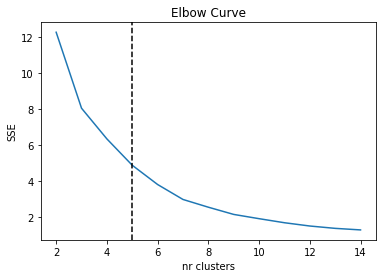

In [47]:
# select optimal number of clusters by minimizing SSE
X =  rets_df.values 
sse = []

random.seed(123)
for k in range(2,15):
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse.append(kmeans.inertia_) #SSE for each cluster
    
pl.plot(range(2,15), sse)
pl.title("Elbow Curve")
pl.xlabel('nr clusters')
pl.ylabel('SSE')
pl.axvline(x=5, c = "k", linestyle='dashed')
pl.show()

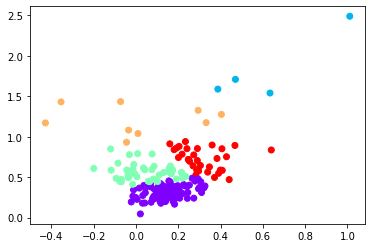

In [65]:
# fit k-means with 5 clusters
X = rets_df.values 
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters).fit(X)
centroids = kmeans.cluster_centers_

pl.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap = "rainbow")
pl.show()

In [ ]:
# remove outlier (rerun previous chunk afterwards)
outlier = mean_ret.idxmax()

rets_df.drop(outlier, inplace = True)
returns.drop(outlier, 1, inplace = True)
ret_test.drop(outlier, 1 , inplace = True)
ret_train.drop(outlier, 1, inplace = True)

# count number of elements in each cluster
cluster_idx = np.array(kmeans.labels_)
(unique, counts) = np.unique(cluster_idx, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

# get cluster number for each asset
asset = pd.DataFrame(rets_df.index)
cluster_list = pd.concat([asset, pd.DataFrame(cluster_idx)],axis = 1)
cluster_list.columns = ["Asset","Cluster"]

## Bounded K means

In [49]:
class ClustersUtils:
    
    @classmethod
    def compute_dist_array(cls, X: np.array) -> np.array:
        dist_array = np.array([[np.linalg.norm(x1 - x2)
                                for x1 in X]
                               for x2 in X])
        return dist_array
    
    @classmethod
    def scatter_plot(cls, X: np.array, clusters_in_idxs: [[int]], centroid_idxs: [int] = None):
        """Only plots first two dimensions"""
        x, y = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                          for one_cluster_in_idxs in clusters_in_idxs
                          for c_idx in one_cluster_in_idxs]))
        c = [color_idx
             for color_idx, one_cluster_in_idxs in enumerate(clusters_in_idxs)
             for _ in one_cluster_in_idxs]
        df = pd.DataFrame({'x': x, 'y': y, 'c': c})

        fig, ax = plt.subplots()
        for color_idx, cluster_in_idxs in enumerate(clusters_in_idxs):
            df_temp = df[df['c'].isin([color_idx])]
            plt.plot(df_temp['x'].tolist(), df_temp['y'].tolist(), 'o', label=color_idx, markersize=5)

        if centroid_idxs is not None:
            x_c, y_c = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                                  for c_idx in centroid_idxs]))
            plt.plot(x_c, y_c, 'o', color='black', markersize=3)

        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
        
    @classmethod
    def plot_families_on_map(cls, points_coords_lng_lat: [[float]], family_size: np.array) -> None:
        features = []
        color = "#251782"
        for lng_lat, s in zip(points_coords_lng_lat, family_size):
            p = Feature(geometry=GeojsonPoint(lng_lat), 
                        properties={"marker-symbol": int(s), "marker-color": color})
            features += [p]

        feature_collection = FeatureCollection(features=features)
        geojsonio.display(json.dumps(feature_collection));
        
    @classmethod
    def plot_clustering_on_map(cls, clusters_in_idxs: [[int]], 
                               points_coords_lng_lat: [[float]], family_size: np.array) -> None:
        features = []
        for cluster_idxs in clusters_in_idxs:
            color = "#" + ''.join(random.choices('0123456789abcdef', k=6))
            for idx in cluster_idxs:
                properties = {"marker-symbol": int(family_size[idx]), "marker-color": color}
                p = Feature(geometry=GeojsonPoint(points_coords_lng_lat[idx]), properties=properties)
                features += [p]

        feature_collection = FeatureCollection(features=features)
        geojsonio.display(json.dumps(feature_collection));
        
class BoundedKMeansClustering:
    def __init__(self, n_clusters: int, max_cluster_size: int, n_iter: int = 10, n_init: int = 10, plot_every_iteration=False):
        self.n_clusters = n_clusters
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.plot_every_iteration = plot_every_iteration

        self.n_points = None

    def fit(self, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        self.n_points = X.shape[0]
        dist_array = dist_array if dist_array is not None else ClustersUtils.compute_dist_array(X)

        costs, clusters = zip(*[self.fit_one_iteration(X, weights, dist_array) for _ in range(self.n_init)])

        if all(np.isnan(np.array(costs))):
            return np.nan, np.nan
        
        best_idx = np.nanargmin(costs)
        best_cost = costs[best_idx]
        best_clusters = clusters[best_idx]

        self.n_points = None
        return best_cost, best_clusters

    def fit_one_iteration(self, X: np.array, weights: np.array, dist_array: np.array) -> [float, [[int]]]:
        # inspired by https://core.ac.uk/download/pdf/61217069.pdf

        try:
            clusters_in_idxs = self._initialize_clusters(weights, dist_array)
            best_clusters = clusters_in_idxs
            best_cost = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)

            for i in range(self.n_iter):
                clusters_in_idxs, maximal_mean_dist_in_clusters = self._optimize_clusters(X, weights, dist_array,
                                                                                          clusters_in_idxs)
                if clusters_in_idxs == best_clusters:
                    # print(f"Reached a local optimum after {i} iterations.")
                    break
                
                if maximal_mean_dist_in_clusters < best_cost:
                    best_cost = maximal_mean_dist_in_clusters
                    best_clusters = clusters_in_idxs
                    
            if self.plot_every_iteration:
                ClustersUtils.scatter_plot(X, best_clusters)

        except ValueError:
            best_cost, best_clusters = np.nan, np.nan

        return best_cost, best_clusters

    def _initialize_clusters(self, weights: np.array, dist_array: np.array) -> [[int]]:
        centroid_idxs = random.sample(range(self.n_points), self.n_clusters)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        return clusters_in_idxs

    def _assign_points_to_clusters(self, weights: np.array, dist_array: np.array, centroid_idxs: [int]) -> [[int]]:
        clusters_in_idxs = [[c_idx] for c_idx in centroid_idxs]
        cluster_weights = np.array([weights[c_idx] for c_idx in centroid_idxs])

        sorted_points_idxs_by_weights = [i for i in np.argsort(-weights,  axis=0) if i not in centroid_idxs]
        for p_idx in sorted_points_idxs_by_weights:
            is_assigned = False
            sorted_cluster_idxs_by_dist = np.argsort(dist_array[p_idx][centroid_idxs])
            for c_idx in sorted_cluster_idxs_by_dist:
                if cluster_weights[c_idx] + weights[p_idx] <= self.max_cluster_size:
                    clusters_in_idxs[c_idx].append(p_idx)
                    cluster_weights[c_idx] += weights[p_idx]
                    is_assigned = True
                    break
            if not is_assigned:
                raise ValueError(
                    f"Point {p_idx} could not be assigned. Try with more than {self.n_clusters} clusters. "
                    f"Current_clusters in idxs: {clusters_in_idxs}")

        return clusters_in_idxs

    def _get_maximal_mean_dist_in_clusters(self, dist_array: np.array, clusters_in_idxs: [[int]]):
        mean_dist_in_all_clusters = [self._get_mean_dist_in_cluster(dist_array, one_cluster_in_idxs)
                                     for one_cluster_in_idxs in clusters_in_idxs]
        maximal_mean_dist_in_clusters = max(mean_dist_in_all_clusters)
        return maximal_mean_dist_in_clusters

    def _get_mean_dist_in_cluster(self, dist_array: np.array, cluster_in_idxs: [[int]]) -> float:
        cluster_sub_dist_array = dist_array[cluster_in_idxs, :][:, cluster_in_idxs]
        cluster_sub_dist_array_triu = np.triu(cluster_sub_dist_array)
        cluster_sub_dist_array_triu[cluster_sub_dist_array_triu == 0] = np.nan
        mean_dist_in_cluster = np.nanmean(cluster_sub_dist_array)
        return mean_dist_in_cluster

    def _optimize_clusters(self, X: np.array, weights: np.array, dist_array: np.array, clusters_in_idxs: [[int]]):
        centroid_idxs = self._update_centroids(X, clusters_in_idxs)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        maximal_mean_dist_in_clusters = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)        
        return clusters_in_idxs, maximal_mean_dist_in_clusters

    def _update_centroids(self, X: np.array, clusters_in_idxs: [[int]]) -> [int]:
        updated_centroid_idxs = [self._update_centroid_for_one_cluster(X, one_cluster_in_idxs)
                                 for one_cluster_in_idxs in clusters_in_idxs]
        return updated_centroid_idxs

    def _update_centroid_for_one_cluster(self, X: np.array, cluster_in_idxs: [int]) -> int:
        center = np.mean(X[cluster_in_idxs], axis=0)
        closest_point_idx_in_cluster = np.argmin(np.linalg.norm(X[cluster_in_idxs] - center, axis=1))
        closest_point_idx = cluster_in_idxs[closest_point_idx_in_cluster]
        return closest_point_idx
    
class BoundedClustering:
    def __init__(self, max_cluster_size: int, n_iter: int = 10, n_init: int = 10, n_k_to_try: int = 10, 
                 plot_every_iteration: bool = False, plot_edge_values: bool = False):
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.n_k_to_try = n_k_to_try
        self.plot_every_iteration = plot_every_iteration
        self.plot_edge_values = plot_edge_values

    def fit(self, X: np.array, weights: np.array) -> [float, [[int]]]:
        min_n_clusters = int(np.ceil(sum(weights) / self.max_cluster_size))
        max_n_clusters = min([min_n_clusters + self.n_k_to_try, len(weights)])
        all_k = list(range(min_n_clusters, max_n_clusters + 1))

        dist_array = ClustersUtils.compute_dist_array(X)
        costs, clusters = zip(*[self._fit_k(k, X, weights, dist_array) for k in all_k])

        if np.isnan(np.array(costs)).all():
            raise NotEnoughClustersException(f"Could not produce any clustering with range {all_k}.")

        valid_k_indices, all_points = zip(*[[i, np.array([k, cost])]
                                            for i, (k, cost) in enumerate(zip(all_k, costs))
                                            if not np.isnan(cost)])
        if len(valid_k_indices) <= 2:
            i = valid_k_indices[0]
            return all_k[i], clusters[i]

        p_left, p_right = all_points[0], all_points[-1]
        all_distances_from_line = [self._dist_from_line(p_left, p_right, p) for p in all_points]
        
        best_k_idx_in_all_points = int(np.argmax(all_distances_from_line))
        self._plot_elbow(all_points, best_k_idx_in_all_points)
        
        if self.plot_edge_values:
            ClustersUtils.scatter_plot(X, clusters[valid_k_indices[0]])
            ClustersUtils.scatter_plot(X, clusters[valid_k_indices[-1]])
        
        best_k_idx_in_all_ks = valid_k_indices[best_k_idx_in_all_points]
        best_n_clusters, best_clusters = all_k[best_k_idx_in_all_ks], clusters[best_k_idx_in_all_ks]
        return best_n_clusters, best_clusters
    
    def _fit_k(self, k: int, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        cluster_maker = BoundedKMeansClustering(k, self.max_cluster_size, self.n_iter, self.n_init)
        best_cost, best_clusters = cluster_maker.fit(X, weights, dist_array)
        return best_cost, best_clusters
    
    def _dist_from_line(self, p_left: np.array, p_right: np.array, p: np.array) -> float:
        # minus sign because we expect the point to be below the line
        d = -np.cross(p_right - p_left, p - p_left) / np.linalg.norm(p_right - p_left)
        return d
    
    def _plot_elbow(self, all_points, best_k_idx_in_all_points) -> None:
        points_list = np.array(all_points).T.tolist()
        plt.plot(points_list[0], points_list[1]);
        plt.plot([points_list[0][0], points_list[0][-1]], [points_list[1][0], points_list[1][-1]]);
        plt.scatter(all_points[best_k_idx_in_all_points][0], all_points[best_k_idx_in_all_points][1]);
        plt.xlabel('Number of clusters');
        plt.ylabel('Cost');

Best partition was found for 9 clusters, computed in 7.55 seconds.
Total weight = 198.0
Max_cluster_size = 44.0
Clusters weights: {0: 3.0, 1: 26.0, 2: 35.0, 3: 26.0, 4: 22.0, 5: 36.0, 6: 1.0, 7: 44.0, 8: 5.0}


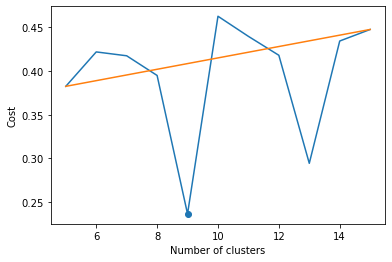

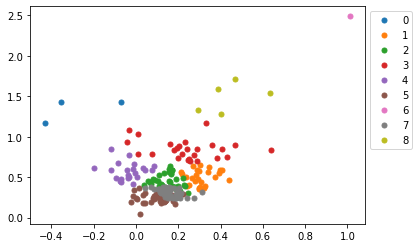

In [56]:
n_clusters = 5
weights = np.ones(len(X))
max_cluster_size = (sum(weights) // n_clusters) + n_clusters

t = time.time()
cluster_maker = BoundedClustering(max_cluster_size, 10)
best_k, best_clusters = cluster_maker.fit(X, weights)
print(f"Best partition was found for {best_k} clusters, computed in {round(time.time() - t, 2)} seconds.")
print(f"Total weight = {sum(weights)}")
print(f"Max_cluster_size = {max_cluster_size}")
print(f"Clusters weights: {dict((i, sum(weights[c])) for i, c in enumerate(best_clusters))}")
ClustersUtils.scatter_plot(X, best_clusters)

## Rolling portfolio optimization K-Means

In [ ]:
# save return series for each cluster in dictionary
ret_dict = cluster_returns(x = cluster_list, y = ret_test)

In [ ]:
# compute equally weighted portfolio returns for each cluster
ret_ew = equal_weights(ret_dict)

In [ ]:
# optimal portfolio weights on 252 days rolling windows (daily portfolio rebalancing)
pesi_rol = rolling_portfolio(ret_ew, clust_type = "partitional")

In [ ]:
# make sure return dates match weight dates 
lgc = ret_ew.index.isin(pesi_rol.index)
ret_subs = ret_ew.iloc[lgc, :]

# select dates for portfolio backtest
dates_backtest = ret_subs.index

In [ ]:
# portfolio returns
kmeans_rets = (ret_subs*pesi_rol).sum(axis = 1)

# cumulative returns
kmeans_rol = cumulative_returns(pf_returns = kmeans_rets)

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(kmeans_rol)
ax1.set_xlabel('Date')
ax1.set_ylabel("%")
ax1.set_title("Portfolio Cumulative Returns")
plt.show();

## Static portfolio optimization K-Means

In [ ]:
# static portfolio optimization
pesi_static = static_portfolio(ret_ew)

In [ ]:
# portfolio returns
kmeans_rets_static = (ret_ew*list(pesi_static.values())).sum(axis = 1)

# cumulative returns
kmeans_static = cumulative_returns(pf_returns = kmeans_rets_static)

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(kmeans_static)
ax1.set_xlabel('Date')
ax1.set_ylabel("%")
ax1.set_title("Portfolio Cumulative Returns")
plt.show();

In [ ]:
# # calculate portfolio weights for each asset
# kmeans_w = pd.DataFrame()

# names_assets = pd.Index([])

# for i in pesi_static.keys():
    
#     w = pesi_static[i]
#     pesi = [w*1/len(ret_dict[i].columns)]*len(ret_dict[i].columns)
#     kmeans_w = kmeans_w.append( pd.DataFrame(pesi) )
#     names_assets = names_assets.union( ret_dict[i].columns )

# kmeans_w.index = names_assets

In [ ]:
# excess return from daily rebalancing
extraret = kmeans_rol - kmeans_static

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(extraret)
ax1.set_xlabel('Date')
ax1.set_ylabel("%")
ax1.set_title("Excess Return")
plt.show();

# Hierarchical risk parity

In [ ]:
# hrp clusters (pyhrp package)
cov, cor = ret_train.cov(), ret_train.corr()
links = linkage(dist(cor.values), method='ward')
node = tree(links)

#rootcluster = _hrp(node, cov)
#weights_hrp = rootcluster.weights

fig = plt.figure(figsize=(15,7))
ax = dendrogram(links, orientation="top")

## Static portfolio optimization HRP

In [ ]:
# static portfolio weights (pypfopt package)
hrp = hierarchical_portfolio.HRPOpt(ret_train)
raw_weights = hrp.optimize()
weights_hrp = hrp.clean_weights()
# cluster = hrp.clusters

In [ ]:
# portfolio returns
hrp_rets_static = (ret_test*list(weights_hrp.values())).sum(axis = 1)

# cumulative returns
hrp_static = cumulative_returns(pf_returns = hrp_rets_static)

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(hrp_static)
ax1.set_xlabel('Date')
ax1.set_ylabel("%")
ax1.set_title("Portfolio Cumulative Returns")
plt.show();

## Rolling portfolio optimization HRP

In [ ]:
# hrp_pesirol = rolling_portfolio(ret_test, clust_type = "hierarchical")

#hrp_pesirol.to_pickle("./pesi_rolling_hrp.pkl")

In [ ]:
# import rolling hrp weights
hrp_pesirol = pd.read_pickle("./pesi_rolling_hrp.pkl")

hrp_pesirol.columns = ret_test.columns

In [ ]:
# portfolio returns
hrp_rets_rol = (ret_test*hrp_pesirol).sum(axis = 1)

# cumulative returns
hrp_rol = cumulative_returns(pf_returns = hrp_rets_rol)

In [ ]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(hrp_rol)
ax1.set_xlabel('Date')
ax1.set_ylabel("%")
ax1.set_title("Portfolio Cumulative Returns")
plt.show();